In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.svm import OneClassSVM
from sklearn.cluster import DBSCAN, KMeans
from sklearn.neighbors import LocalOutlierFactor, NearestNeighbors
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import silhouette_score, confusion_matrix, classification_report, cohen_kappa_score
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import make_scorer
from sklearn.covariance import MinCovDet

import shap
import xgboost as xgb
import datetime
from scipy import stats

c:\Users\USER\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Loading and Inspection

In [54]:
file_path = r"C:\Users\USER\Downloads\bank_transactions_data.csv"
df = pd.read_csv(file_path)

df.head()

,TransactionID,AccountID,TransactionAmount,TransactionDate,TransactionType,Location,DeviceID,IP Address,MerchantID,Channel,CustomerAge,CustomerOccupation,TransactionDuration,LoginAttempts,AccountBalance,PreviousTransactionDate
0,TX000001,AC00128,14.09,11/4/2023 16:29,Debit,San Diego,D000380,162.198.218.92,M015,ATM,70,Doctor,81,1,5112.21,4/11/2024 8:08
1,TX000002,AC00455,376.24,27/6/2023 16:44,Debit,Houston,D000051,13.149.61.4,M052,ATM,68,Doctor,141,1,13758.91,4/11/2024 8:09
2,TX000003,AC00019,126.29,10/7/2023 18:16,Debit,Mesa,D000235,215.97.143.157,M009,Online,19,Student,56,1,1122.35,4/11/2024 8:07
3,TX000004,AC00070,184.50,5/5/2023 16:32,Debit,Raleigh,D000187,200.13.225.150,M002,Online,26,Student,25,1,8569.06,4/11/2024 8:09
4,TX000005,AC00411,13.45,16/10/2023 17:51,Credit,Atlanta,D000308,65.164.3.100,M091,Online,26,Student,198,1,7429.40,4/11/2024 8:06


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2512 entries, 0 to 2511
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   TransactionID            2512 non-null   object 
 1   AccountID                2512 non-null   object 
 2   TransactionAmount        2512 non-null   float64
 3   TransactionDate          2512 non-null   object 
 4   TransactionType          2512 non-null   object 
 5   Location                 2512 non-null   object 
 6   DeviceID                 2512 non-null   object 
 7   IP Address               2512 non-null   object 
 8   MerchantID               2512 non-null   object 
 9   Channel                  2512 non-null   object 
 10  CustomerAge              2512 non-null   int64  
 11  CustomerOccupation       2512 non-null   object 
 12  TransactionDuration      2512 non-null   int64  
 13  LoginAttempts            2512 non-null   int64  
 14  AccountBalance          

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
TransactionAmount,2512.0,297.593778,291.946243,0.26,81.885,211.14,414.5275,1919.11
CustomerAge,2512.0,44.673965,17.792198,18.00,27.000,45.00,59.0000,80.00
TransactionDuration,2512.0,119.643312,69.963757,10.00,63.000,112.50,161.0000,300.00
LoginAttempts,2512.0,1.124602,0.602662,1.00,1.000,1.00,1.0000,5.00
AccountBalance,2512.0,5114.302966,3900.942499,101.25,1504.370,4735.51,7678.8200,14977.99


In [55]:
# Column type separation
id_cols = ['TransactionID', 'AccountID']
date_cols = ['TransactionDate', 'PreviousTransactionDate']

# Convert to datetime
for col in date_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce', dayfirst=True)

# Identify numeric vs categorical
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)

Numeric columns: ['TransactionAmount', 'CustomerAge', 'TransactionDuration', 'LoginAttempts', 'AccountBalance']
Categorical columns: ['TransactionID', 'AccountID', 'TransactionType', 'Location', 'DeviceID', 'IP Address', 'MerchantID', 'Channel', 'CustomerOccupation']


# Exploratory Data Analysis (EDA)

Univariate Analysis (Numerical Features)

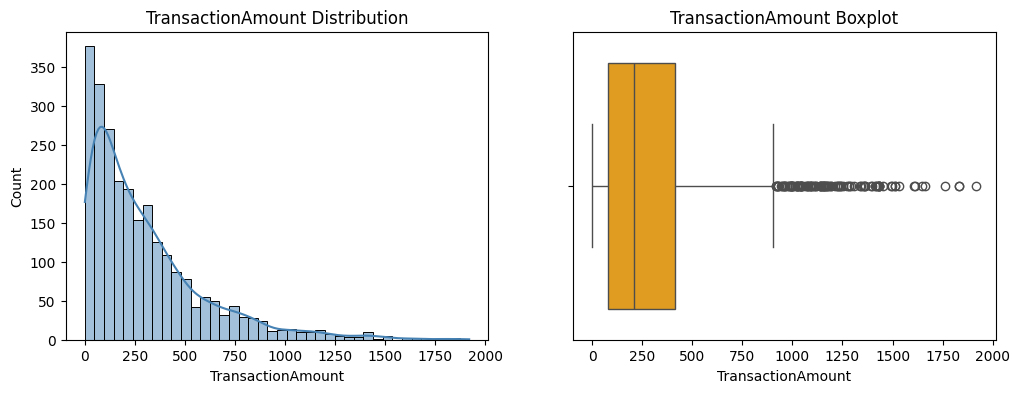

count    2512.000000
mean      297.593778
std       291.946243
min         0.260000
25%        81.885000
50%       211.140000
75%       414.527500
max      1919.110000
Name: TransactionAmount, dtype: float64
Skewness: 1.74, Kurtosis: 3.64



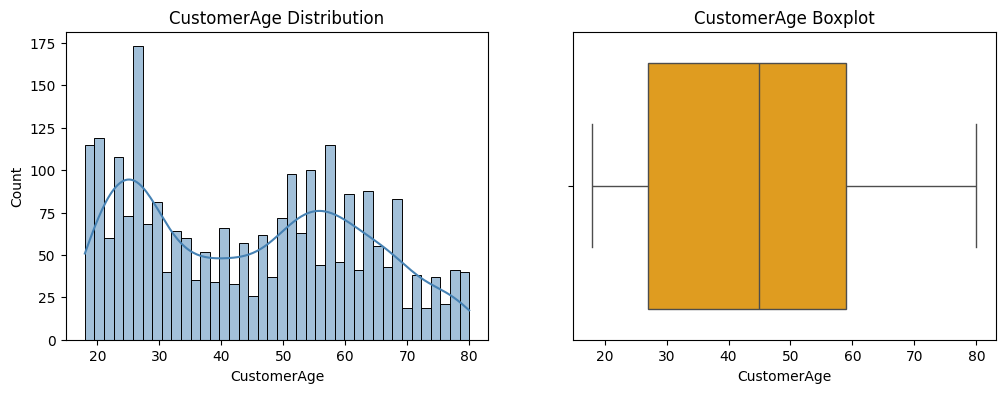

count    2512.000000
mean       44.673965
std        17.792198
min        18.000000
25%        27.000000
50%        45.000000
75%        59.000000
max        80.000000
Name: CustomerAge, dtype: float64
Skewness: 0.15, Kurtosis: -1.22



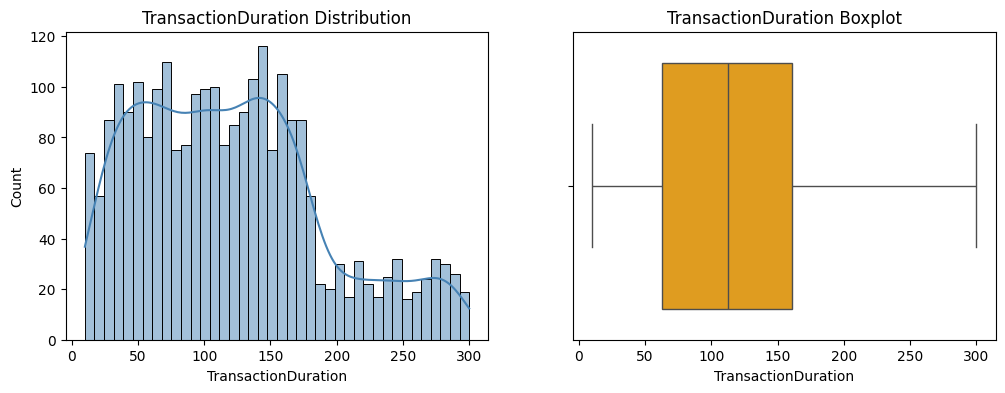

count    2512.000000
mean      119.643312
std        69.963757
min        10.000000
25%        63.000000
50%       112.500000
75%       161.000000
max       300.000000
Name: TransactionDuration, dtype: float64
Skewness: 0.60, Kurtosis: -0.26



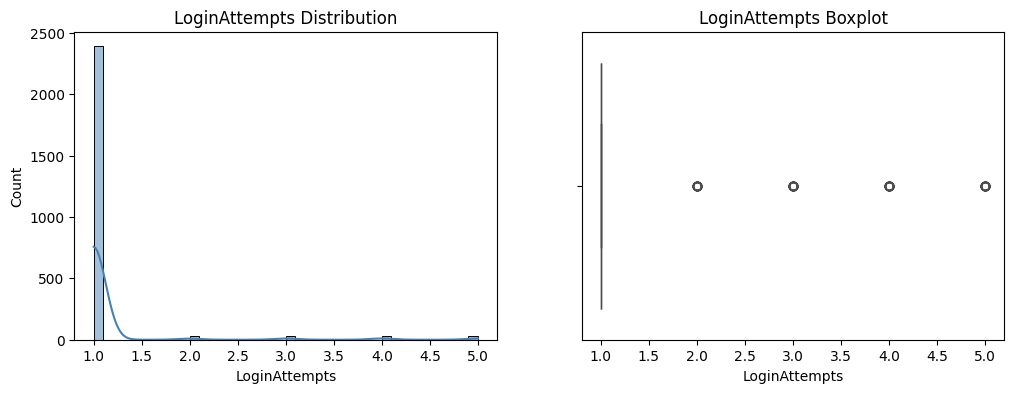

count    2512.000000
mean        1.124602
std         0.602662
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         5.000000
Name: LoginAttempts, dtype: float64
Skewness: 5.17, Kurtosis: 26.67



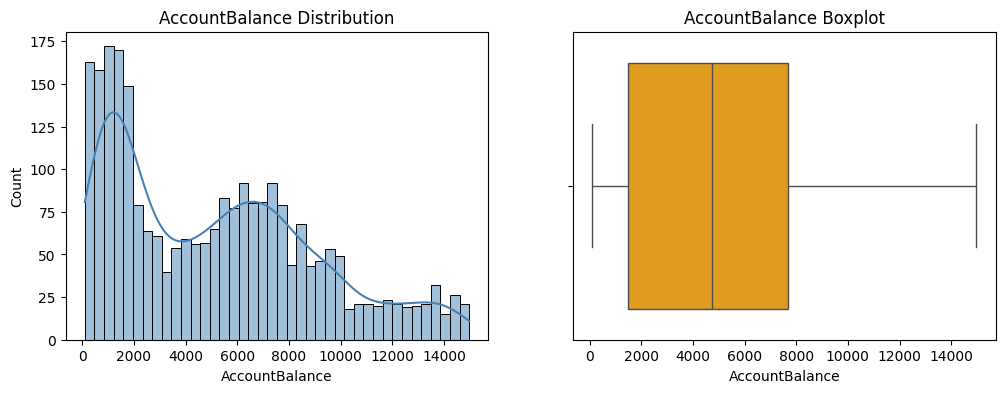

count     2512.000000
mean      5114.302966
std       3900.942499
min        101.250000
25%       1504.370000
50%       4735.510000
75%       7678.820000
max      14977.990000
Name: AccountBalance, dtype: float64
Skewness: 0.60, Kurtosis: -0.56



In [12]:
for col in numeric_cols:
    fig, axes = plt.subplots(1, 2, figsize=(12,4))
    sns.histplot(df[col], kde=True, bins=40, ax=axes[0], color="steelblue")
    axes[0].set_title(f"{col} Distribution")
    sns.boxplot(x=df[col], ax=axes[1], color="orange")
    axes[1].set_title(f"{col} Boxplot")
    plt.show()
    print(df[col].describe().T)
    print(f"Skewness: {df[col].skew():.2f}, Kurtosis: {df[col].kurt():.2f}\n")

Univariate Analysis (Categorical Features)

C:\Users\USER\AppData\Local\Temp\ipykernel_1896\3573709554.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, order=order, palette="viridis")


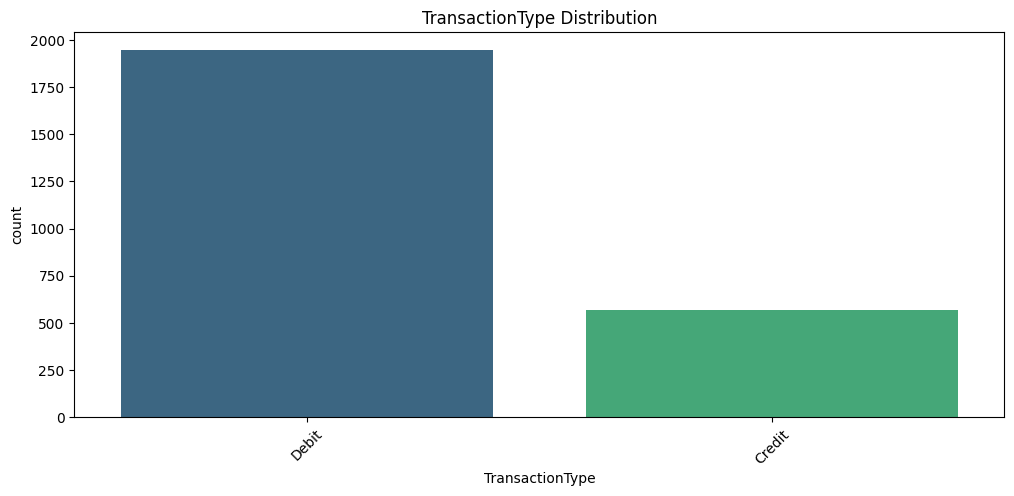

C:\Users\USER\AppData\Local\Temp\ipykernel_1896\3573709554.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, order=order, palette="viridis")


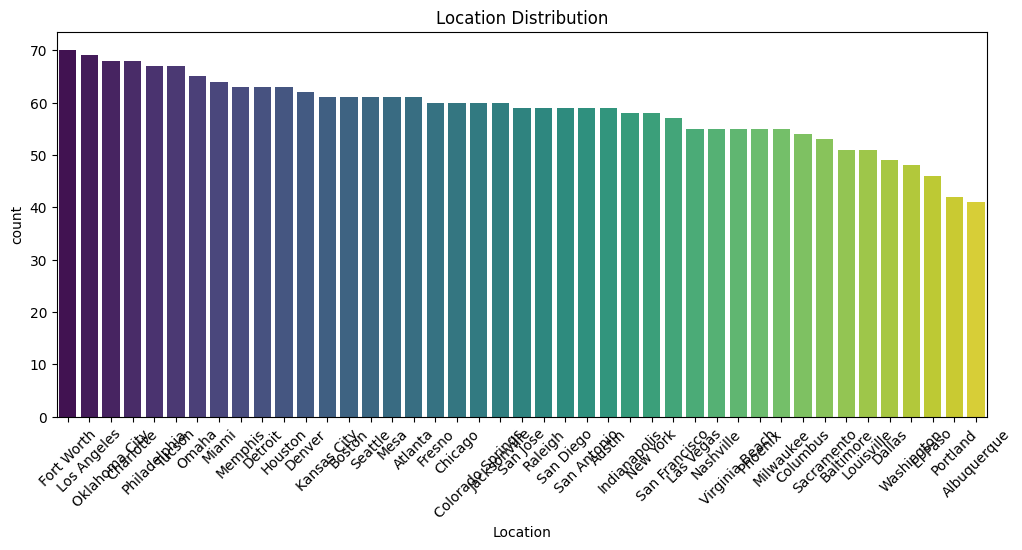

C:\Users\USER\AppData\Local\Temp\ipykernel_1896\3573709554.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, order=order, palette="viridis")


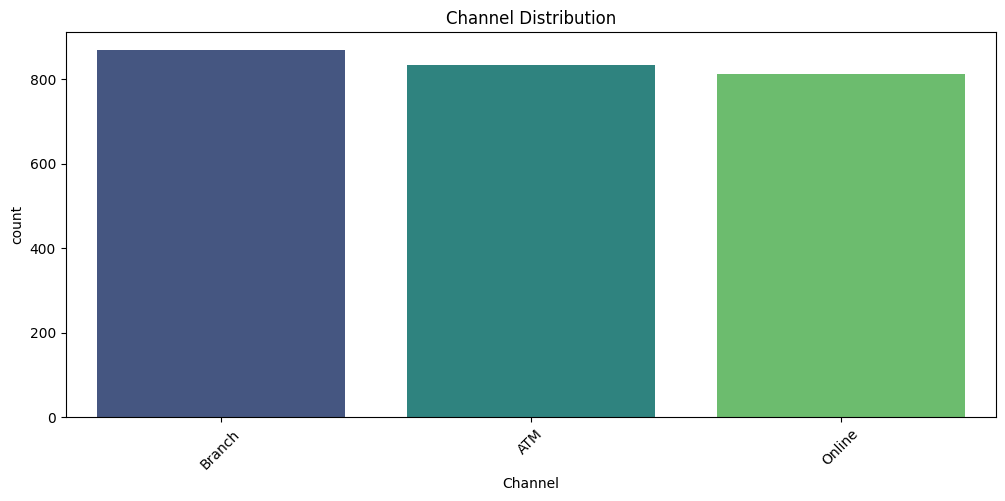

C:\Users\USER\AppData\Local\Temp\ipykernel_1896\3573709554.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, order=order, palette="viridis")


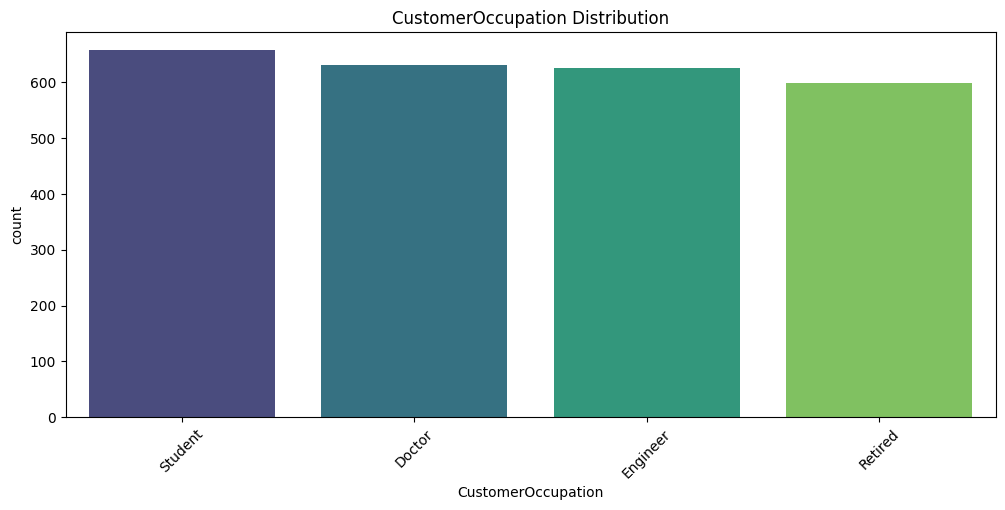

In [13]:
cat_cols = [
    'TransactionType', 
    'Location', 
    'Channel', 
    'CustomerOccupation'
]

for col in cat_cols:
    plt.figure(figsize=(12,5))
    order = df[col].value_counts().index
    sns.countplot(x=col, data=df, order=order, palette="viridis")
    plt.title(f"{col} Distribution")
    plt.xticks(rotation=45)
    plt.show()

Bivariate Analysis (Numeric vs Categorical)

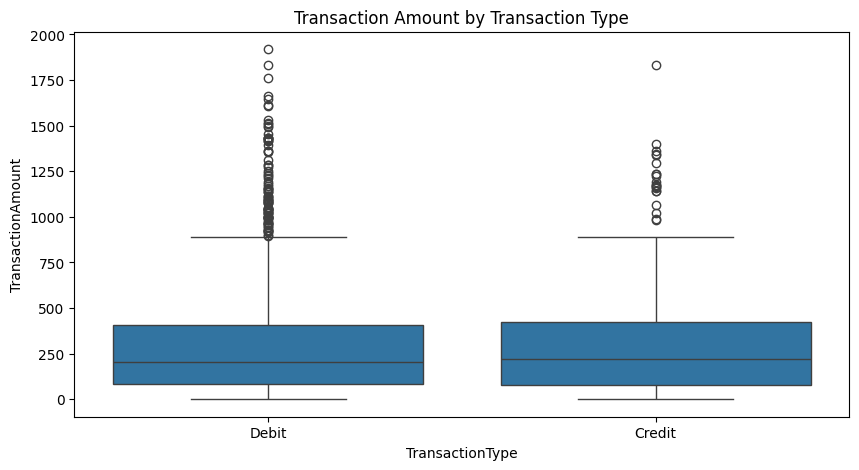

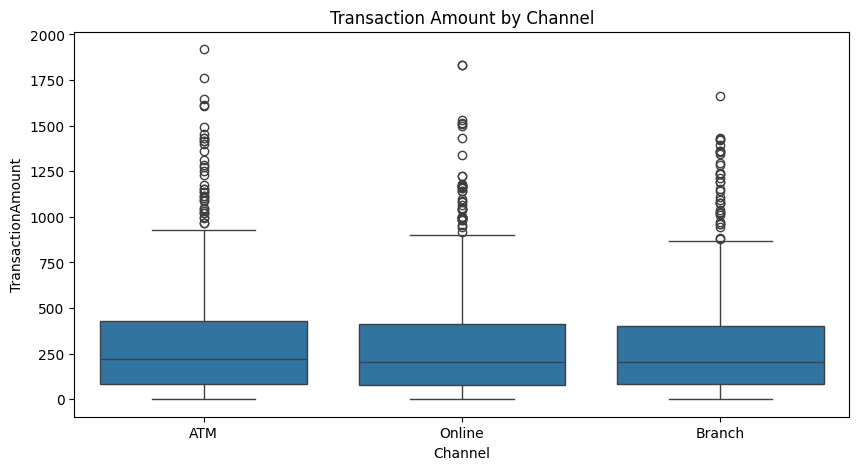

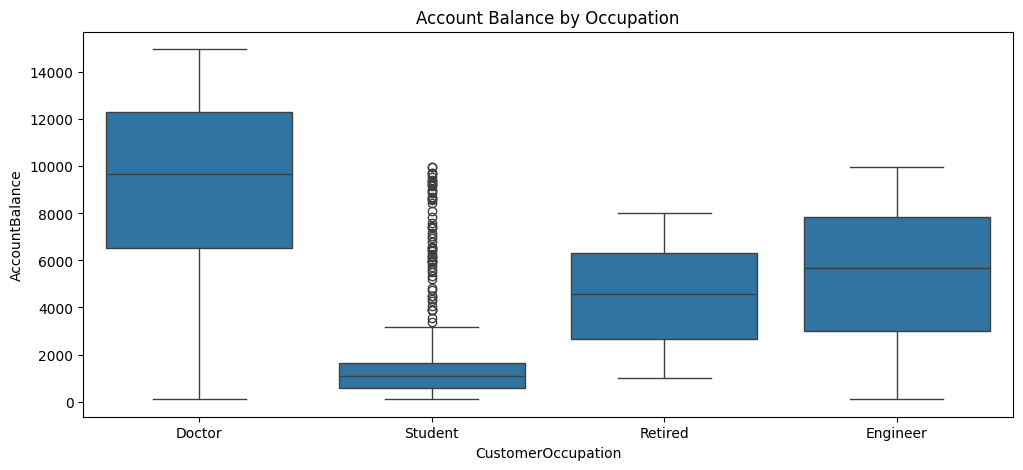

In [18]:
plt.figure(figsize=(10,5))
sns.boxplot(x='TransactionType', y='TransactionAmount', data=df)
plt.title("Transaction Amount by Transaction Type")
plt.show()

plt.figure(figsize=(10,5))
sns.boxplot(x='Channel', y='TransactionAmount', data=df)
plt.title("Transaction Amount by Channel")
plt.show()

plt.figure(figsize=(12,5))
sns.boxplot(x='CustomerOccupation', y='AccountBalance', data=df)
plt.title("Account Balance by Occupation")
plt.show()

Temporal Analysis

C:\Users\USER\AppData\Local\Temp\ipykernel_1896\2401821440.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Hour', data=df, ax=axes[0], palette="viridis")
C:\Users\USER\AppData\Local\Temp\ipykernel_1896\2401821440.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='DayOfWeek', data=df, ax=axes[1], palette="viridis")
C:\Users\USER\AppData\Local\Temp\ipykernel_1896\2401821440.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Month', data=df, ax=axes[2], palette="viridis")


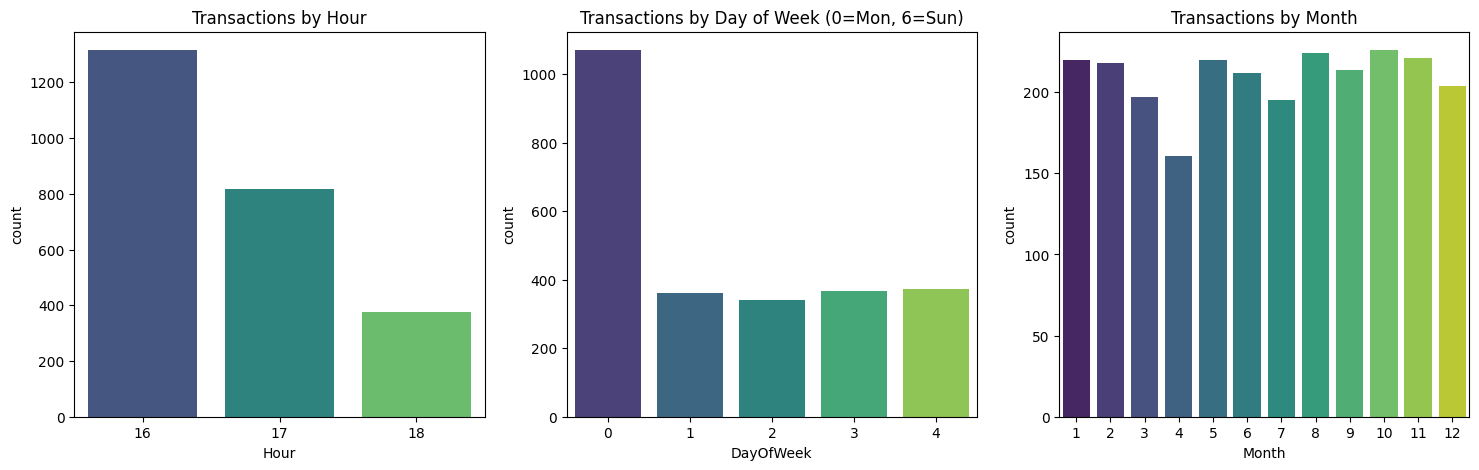

In [57]:
df['Hour'] = df['TransactionDate'].dt.hour
df['DayOfWeek'] = df['TransactionDate'].dt.dayofweek
df['Month'] = df['TransactionDate'].dt.month

fig, axes = plt.subplots(1,3, figsize=(18,5))
sns.countplot(x='Hour', data=df, ax=axes[0], palette="viridis")
axes[0].set_title("Transactions by Hour")

sns.countplot(x='DayOfWeek', data=df, ax=axes[1], palette="viridis")
axes[1].set_title("Transactions by Day of Week (0=Mon, 6=Sun)")

sns.countplot(x='Month', data=df, ax=axes[2], palette="viridis")
axes[2].set_title("Transactions by Month")
plt.show()

Correlation

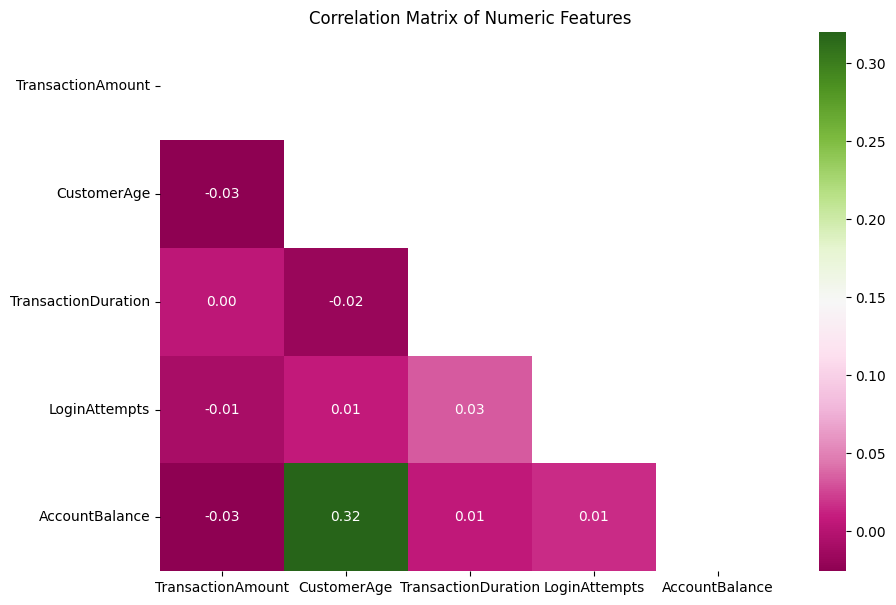

In [22]:
plt.figure(figsize=(10,7))
corr = df[numeric_cols].corr()
sns.heatmap(corr, annot=True, cmap='PiYG', fmt=".2f", mask=np.triu(corr))
plt.title("Correlation Matrix of Numeric Features")
plt.show()

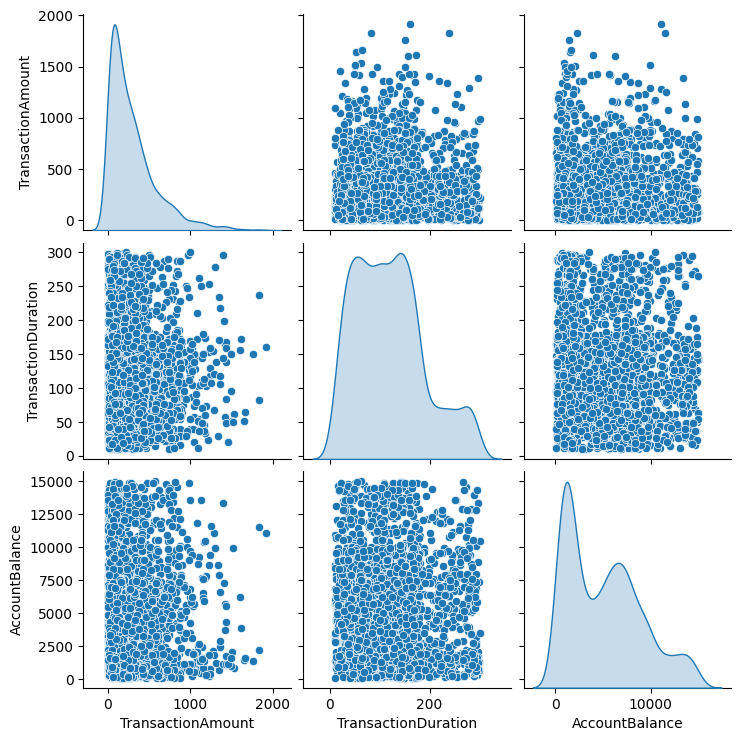

In [23]:
sns.pairplot(df[['TransactionAmount','TransactionDuration','AccountBalance']], diag_kind="kde")
plt.show()

Outlier Analysis

In [58]:
for col in numeric_cols:
    z_scores = stats.zscore(df[col])
    outliers = (np.abs(z_scores) > 3).sum()
    print(f"{col}: {outliers} outliers ({outliers/len(df)*100:.2f}%)")

TransactionAmount: 48 outliers (1.91%)
CustomerAge: 0 outliers (0.00%)
TransactionDuration: 0 outliers (0.00%)
LoginAttempts: 95 outliers (3.78%)
AccountBalance: 0 outliers (0.00%)


# Feature Engineering

In [63]:
df_model = df.copy()
drop_cols = [
    "TransactionID", "AccountID", "TransactionDate",
    "PreviousTransactionDate", "IP Address"
]
df_model.drop(columns=[c for c in drop_cols if c in df_model.columns], inplace=True)
df_model

,TransactionAmount,TransactionType,Location,DeviceID,MerchantID,Channel,CustomerAge,CustomerOccupation,TransactionDuration,LoginAttempts,AccountBalance,Hour,DayOfWeek,Month
0,14.09,Debit,San Diego,D000380,M015,ATM,70,Doctor,81,1,5112.21,16,1,4
1,376.24,Debit,Houston,D000051,M052,ATM,68,Doctor,141,1,13758.91,16,1,6
2,126.29,Debit,Mesa,D000235,M009,Online,19,Student,56,1,1122.35,18,0,7
3,184.50,Debit,Raleigh,D000187,M002,Online,26,Student,25,1,8569.06,16,4,5
4,13.45,Credit,Atlanta,D000308,M091,Online,26,Student,198,1,7429.40,17,0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2507,856.21,Credit,Colorado Springs,D000625,M072,Branch,33,Doctor,109,1,12690.79,17,2,4
2508,251.54,Debit,Tucson,D000410,M029,Branch,48,Doctor,177,1,254.75,17,2,3
2509,28.63,Debit,San Diego,D000095,M087,Branch,56,Retired,146,1,3382.91,17,0,8
2510,185.97,Debit,Denver,D000634,M041,Online,23,Student,19,1,1776.91,16,4,2


In [64]:
# Create ratio feature Amount_to_AvgByType_Ratio (transaction vs. average for its type) 
# Ratio: Transaction amount / average per transaction type
avg_tx_amount_by_type = df_model.groupby("TransactionType")["TransactionAmount"].transform("mean")
df_model["Amount_to_AvgByType_Ratio"] = df_model["TransactionAmount"] / avg_tx_amount_by_type

# Create count of transactions per device (DeviceTxCount) to capture relative behavior
# Device transaction count
device_tx_count = df_model.groupby("DeviceID").size().reset_index(name="DeviceTxCount")
df_model = df_model.merge(device_tx_count, on="DeviceID", how="left")

df_model

,TransactionAmount,TransactionType,Location,DeviceID,MerchantID,Channel,CustomerAge,CustomerOccupation,TransactionDuration,LoginAttempts,AccountBalance,Hour,DayOfWeek,Month,Amount_to_AvgByType_Ratio,DeviceTxCount
0,14.09,Debit,San Diego,D000380,M015,ATM,70,Doctor,81,1,5112.21,16,1,4,0.047764,6
1,376.24,Debit,Houston,D000051,M052,ATM,68,Doctor,141,1,13758.91,16,1,6,1.275428,5
2,126.29,Debit,Mesa,D000235,M009,Online,19,Student,56,1,1122.35,18,0,7,0.428114,5
3,184.50,Debit,Raleigh,D000187,M002,Online,26,Student,25,1,8569.06,16,4,5,0.625442,6
4,13.45,Credit,Atlanta,D000308,M091,Online,26,Student,198,1,7429.40,17,0,10,0.043882,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2507,856.21,Credit,Colorado Springs,D000625,M072,Branch,33,Doctor,109,1,12690.79,17,2,4,2.793498,3
2508,251.54,Debit,Tucson,D000410,M029,Branch,48,Doctor,177,1,254.75,17,2,3,0.852703,5
2509,28.63,Debit,San Diego,D000095,M087,Branch,56,Retired,146,1,3382.91,17,0,8,0.097054,5
2510,185.97,Debit,Denver,D000634,M041,Online,23,Student,19,1,1776.91,16,4,2,0.630425,2


In [65]:
# Encode categorical features
categorical_cols = df_model.select_dtypes(include=["object"]).columns.tolist()

le = LabelEncoder()
for col in categorical_cols:
    df_model[col] = le.fit_transform(df_model[col])

df_model

,TransactionAmount,TransactionType,Location,DeviceID,MerchantID,Channel,CustomerAge,CustomerOccupation,TransactionDuration,LoginAttempts,AccountBalance,Hour,DayOfWeek,Month,Amount_to_AvgByType_Ratio,DeviceTxCount
0,14.09,1,36,365,14,0,70,0,81,1,5112.21,16,1,4,0.047764,6
1,376.24,1,15,50,51,0,68,0,141,1,13758.91,16,1,6,1.275428,5
2,126.29,1,23,229,8,2,19,3,56,1,1122.35,18,0,7,0.428114,5
3,184.50,1,33,182,1,2,26,3,25,1,8569.06,16,4,5,0.625442,6
4,13.45,0,1,298,90,2,26,3,198,1,7429.40,17,0,10,0.043882,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2507,856.21,0,7,605,71,1,33,0,109,1,12690.79,17,2,4,2.793498,3
2508,251.54,1,40,395,28,1,48,0,177,1,254.75,17,2,3,0.852703,5
2509,28.63,1,36,93,86,1,56,2,146,1,3382.91,17,0,8,0.097054,5
2510,185.97,1,10,614,40,2,23,3,19,1,1776.91,16,4,2,0.630425,2


# Principal Component Analysis (PCA)

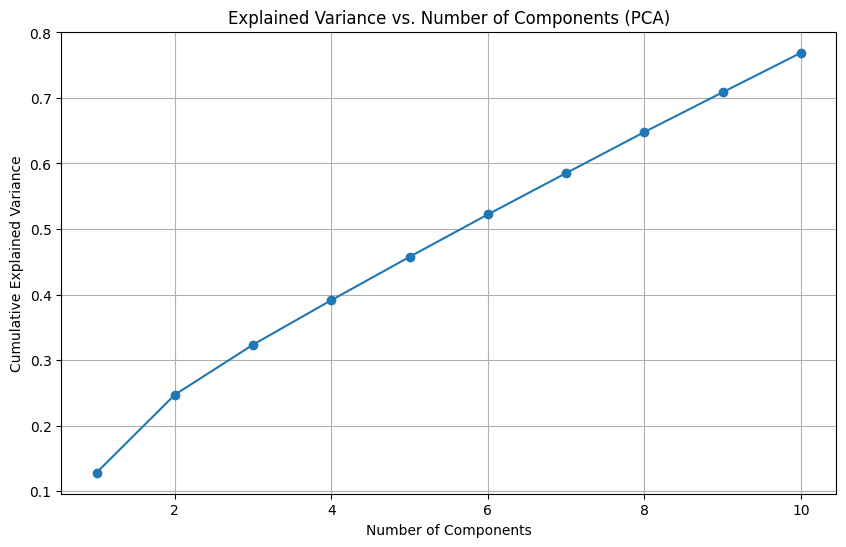

In [ ]:
# Scaling data before PCA
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_model)
df_scaled_df = pd.DataFrame(df_scaled, columns=df_model.columns)

# PCA (linear technique that reduces dimensions by projecting data onto new axes that capture the most variance)
n_components = min(10, len(df_model.columns))
pca = PCA(n_components=n_components, random_state=42)
pca_result = pca.fit_transform(df_scaled)

explained_var = pca.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_var) + 1), cumulative_var, marker="o")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance vs. Number of Components (PCA)")
plt.grid(True)
plt.show()

# t-Distributed Stochastic Neighbor Embedding (t-SNE)


Applying t-SNE for visualization...


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


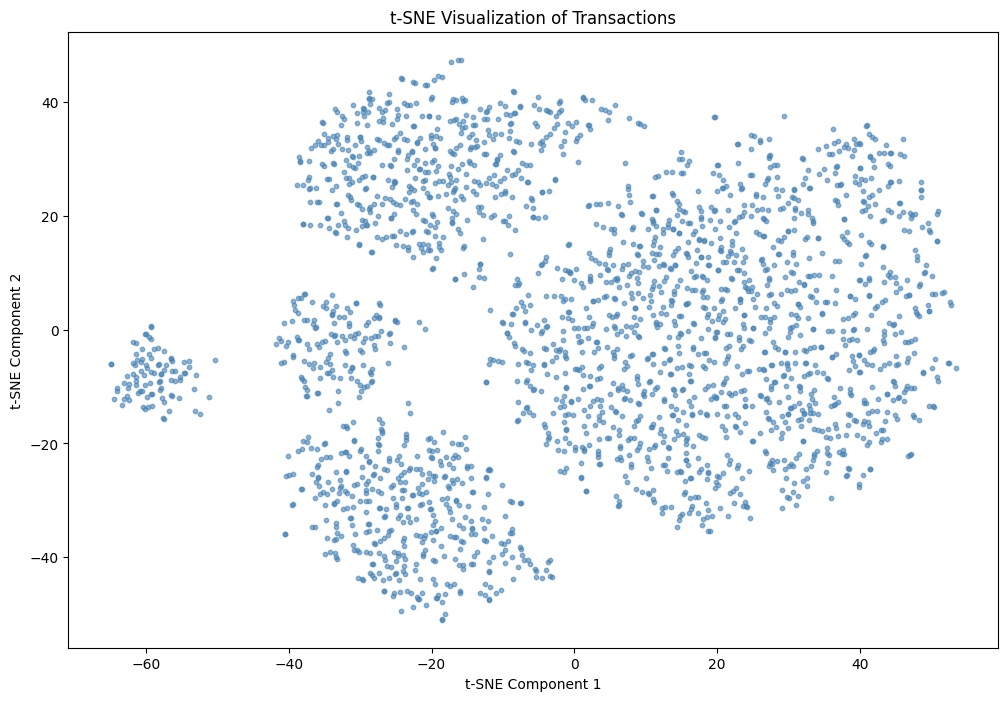

In [75]:
# t-SNE (nonlinear technique that reduces dimensions by preserving local similarities, mainly for visualization of clusters and patterns)
print("\nApplying t-SNE for visualization...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
tsne_results = tsne.fit_transform(df_scaled)

plt.figure(figsize=(12, 8))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], s=10, alpha=0.6, c="steelblue")
plt.title("t-SNE Visualization of Transactions")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

# Anomaly Detection Models

In [126]:
def plot_anomalies(tsne_results, df, label_col, title):
    plt.figure(figsize=(10, 7))
    scatter = sns.scatterplot(
        x=tsne_results[:, 0],
        y=tsne_results[:, 1],
        hue=df[label_col],
        palette={0: "blue", 1: "red"},  # 0 = normal, 1 = anomaly
        alpha=1.0
    )

    plt.title(title)
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")

    # ✅ Fix legend labels
    handles, labels = scatter.get_legend_handles_labels()
    plt.legend(handles, ["Normal", "Anomaly"], title="Status", loc='upper right')

    plt.show()

Minimum Covariance Determinant (MCD)

In [82]:
# Fit Minimum Covariance Determinant (robust covariance estimation)
mcd = MinCovDet(support_fraction=0.75, random_state=42)
mcd.fit(df_scaled_df)

# Compute Mahalanobis distance to the robust center
mahal_dist = mcd.mahalanobis(df_scaled_df)

# Threshold: 97.5th percentile of distances
threshold = np.percentile(mahal_dist, 97.5)

#  Mark anomalies (1 = anomaly, 0 = normal)
df_model["MCD_Anomaly"] = (mahal_dist > threshold).astype(int)
df_model["MCD_Score"] = mahal_dist

C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\sklearn\covariance\_robust_covariance.py:185: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-14.951138262926664 > -85.002251939320317). You may want to try with a higher value of support_fraction (current value: 0.752).
  warnings.warn(
C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\sklearn\covariance\_robust_covariance.py:185: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-19.357028516309498 > -86.367589938268083). You may want to try with a higher value of support_fraction (current value: 0.752).
  warnings.warn(
C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\sklearn\covariance\_robust_covariance.py:185: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-19.126380331041609 > -86.060683343382834). You may want to try with a higher value of support_fra

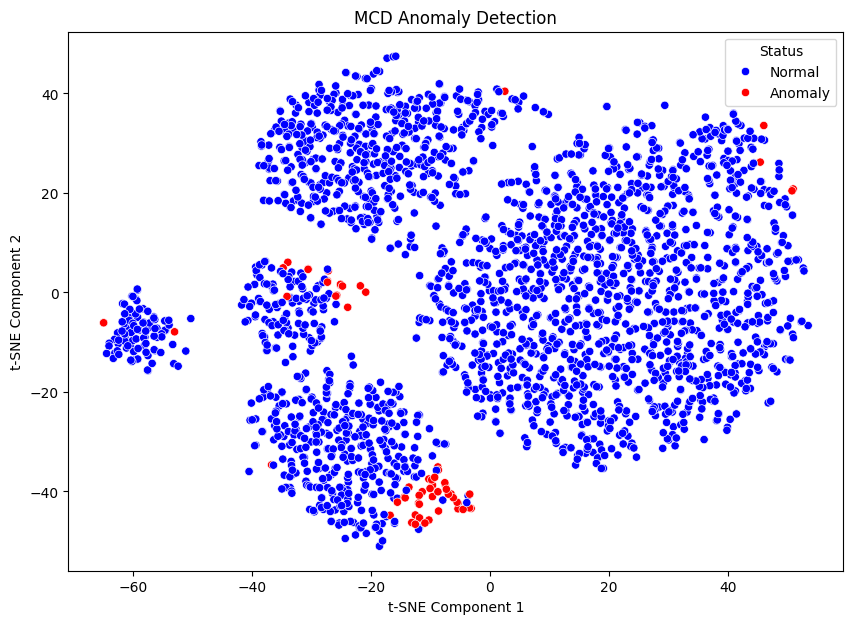

In [127]:
plot_anomalies(tsne_results, df_model, 'MCD_Anomaly', "MCD Anomaly Detection")

Isolation Forest

In [86]:
param_grid = {
    "n_estimators": [100, 200],       # number of trees
    "contamination": [0.01, 0.02, 0.05],  # anomaly proportion
    "max_samples": [100, "auto"]      # samples per tree
}

iso_forest = IsolationForest(random_state=42)

grid_search = GridSearchCV(
    estimator=iso_forest,             # model
    param_grid=param_grid,            # parameters to try
    cv=3,
    scoring="neg_mean_squared_error",
    verbose=0
)

grid_search.fit(df_scaled_df)
print("Best Isolation Forest parameters:", grid_search.best_params_)

best_iso_forest = grid_search.best_estimator_
df_model["IF_Anomaly"] = best_iso_forest.predict(df_scaled_df)   # labels
df_model["IF_Score"] = best_iso_forest.decision_function(df_scaled_df)  # scores
df_model["IF_Anomaly"] = df_model["IF_Anomaly"].map({1: 0, -1: 1})

C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\sklearn\model_selection\_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\sklearn\model_selection\_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\sklearn\model_selection\_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\sklearn\model_selection\_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
TypeError: 

Best Isolation Forest parameters: {'contamination': 0.01, 'max_samples': 100, 'n_estimators': 100}


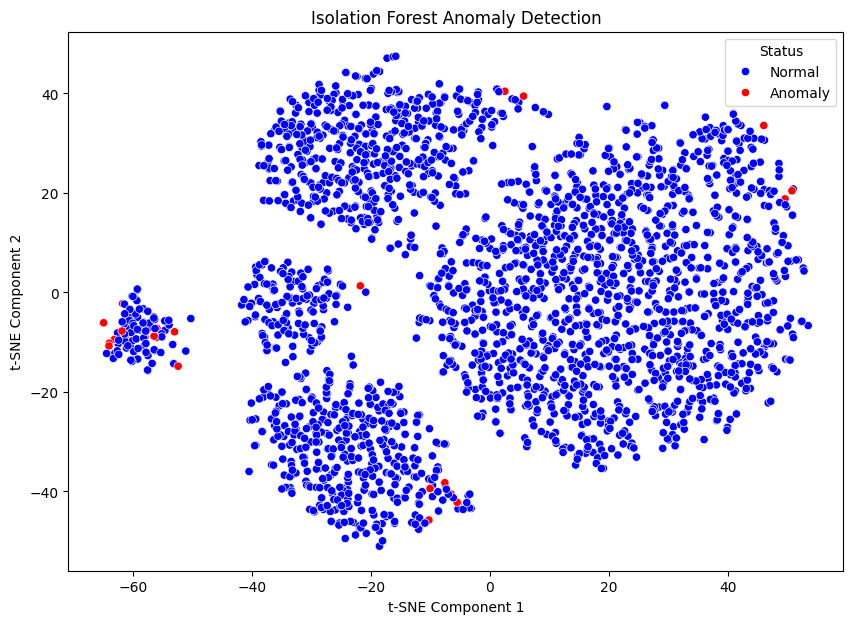

In [128]:
plot_anomalies(tsne_results, df_model, 'IF_Anomaly', "Isolation Forest Anomaly Detection")

Local Outlier Factor (LOF)

In [113]:
# Custom wrapper to make LOF compatible with GridSearchCV
class LOFWrapper(BaseEstimator, TransformerMixin):
    def __init__(self, n_neighbors=20, contamination=0.05, metric="euclidean"):
        self.n_neighbors = n_neighbors
        self.contamination = contamination
        self.metric = metric
        self.model = None
        self.labels_ = None

    def fit(self, X, y=None):
        X = np.array(X, dtype=float)  # ensure numeric numpy array
        self.model = LocalOutlierFactor(
            n_neighbors=self.n_neighbors,
            contamination=self.contamination,
            metric=self.metric
        )
        self.labels_ = self.model.fit_predict(X)
        return self

    def predict(self, X):
        return self.labels_

# Custom scorer: silhouette score (higher = better)
def lof_scorer(estimator, X, y=None):
    X = np.array(X, dtype=float)  # ensure numeric numpy array
    labels = estimator.fit(X).labels_
    if len(set(labels)) > 1:  # avoid invalid silhouette case
        return silhouette_score(X, labels)
    else:
        return -1

scorer = make_scorer(lof_scorer, greater_is_better=True)

# GridSearchCV for LOF
param_grid = {
    'n_neighbors': [10, 20, 30, 50],
    'contamination': [0.01, 0.02, 0.05, 0.1],
    'metric': ['euclidean', 'manhattan']
}

grid_search = GridSearchCV(
    estimator=LOFWrapper(),
    param_grid=param_grid,
    scoring=scorer,
    cv=[(np.arange(len(df_scaled_df)), np.arange(len(df_scaled_df)))],  # use explicit indices
    verbose=1
)

grid_search.fit(df_scaled_df.to_numpy(dtype=float))  # ensure numpy input

print("Best LOF parameters:", grid_search.best_params_)

best_lof = grid_search.best_estimator_
df_model['LOF_Anomaly'] = np.where(best_lof.labels_ == -1, 1, 0)

Fitting 1 folds for each of 32 candidates, totalling 32 fits


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\sklearn\model_selection\_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\sklearn\model_selection\_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\sklearn\model_selection\_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\sklearn\model_selection\_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
TypeError: 

Best LOF parameters: {'contamination': 0.01, 'metric': 'euclidean', 'n_neighbors': 10}


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\sklearn\model_selection\_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\sklearn\model_selection\_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\sklearn\model_selection\_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\sklearn\model_selection\_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
TypeError: 

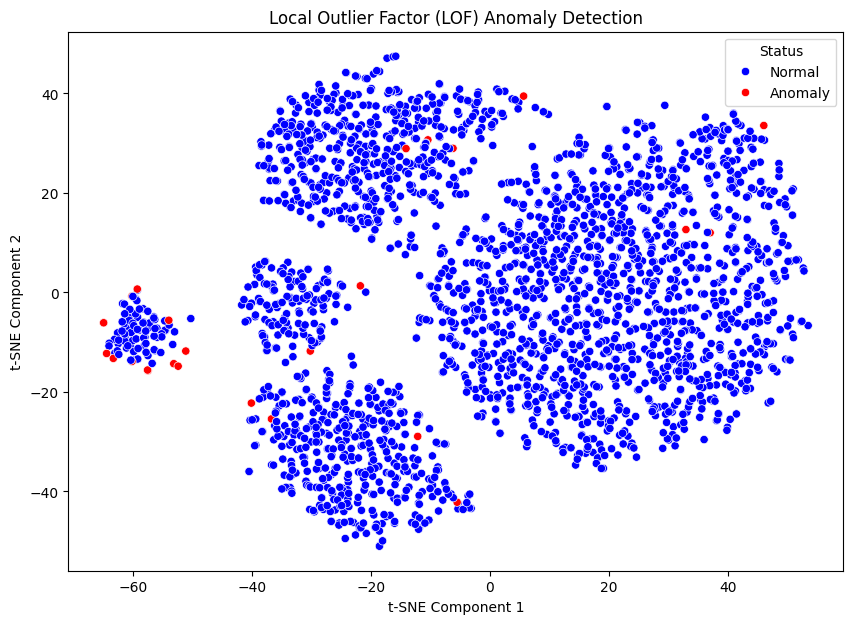

In [129]:
plot_anomalies(tsne_results, df_model, 'LOF_Anomaly', "Local Outlier Factor (LOF) Anomaly Detection")

One-Class SVM

In [91]:
ocsvm = OneClassSVM(nu=0.05, kernel="rbf", gamma="auto")
df_model['OCSVM_Anomaly'] = ocsvm.fit_predict(df_scaled_df)
df_model['OCSVM_Score'] = ocsvm.decision_function(df_scaled_df)

# Map: -1 → anomaly (1), 1 → normal (0)
df_model['OCSVM_Anomaly'] = df_model['OCSVM_Anomaly'].map({1: 0, -1: 1})

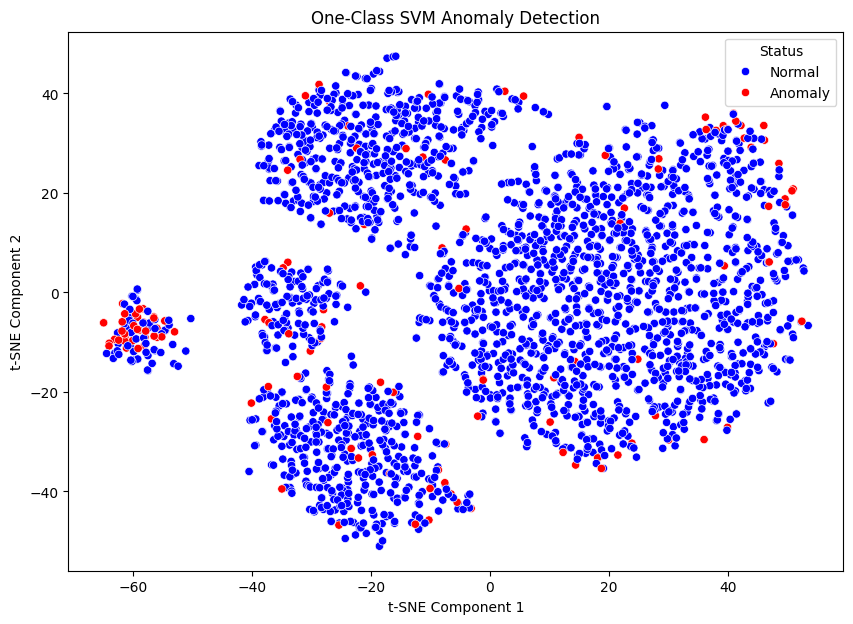

In [130]:
plot_anomalies(tsne_results, df_model, 'OCSVM_Anomaly', "One-Class SVM Anomaly Detection")

# Ensemble Voting

Ensemble Anomalies (majority vote): 37 (1.47%)


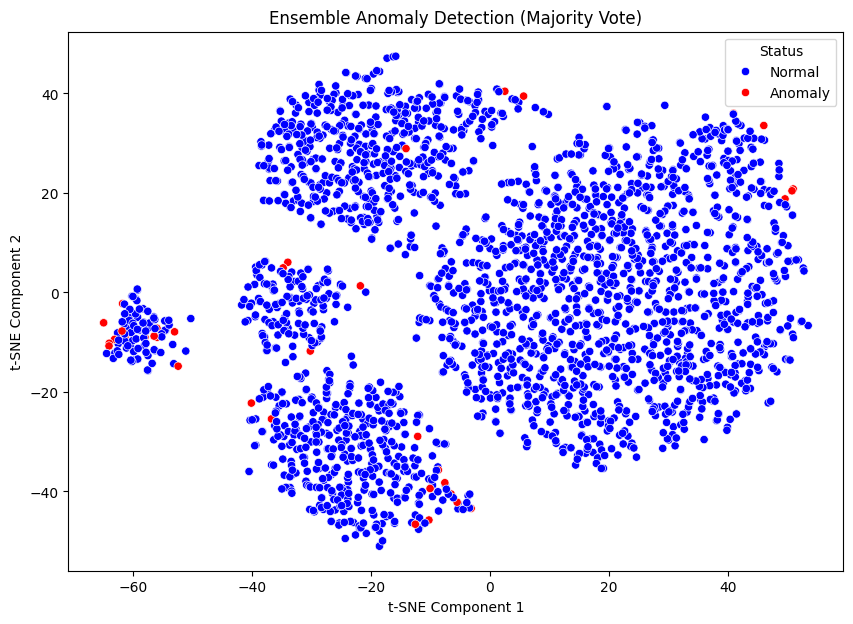

In [ ]:
# Ensemble anomaly detection (majority vote)
df_model['Ensemble_Anomaly'] = (
    (df_model['IF_Anomaly'] + df_model['LOF_Anomaly'] + df_model['OCSVM_Anomaly']+df_model['MCD_Anomaly']) >= 2).astype(int)

print(f"Ensemble Anomalies (majority vote): {df_model['Ensemble_Anomaly'].sum()} "
      f"({df_model['Ensemble_Anomaly'].mean()*100:.2f}%)")

# Visualization
plot_anomalies(tsne_results, df_model, 'Ensemble_Anomaly',                "Ensemble Anomaly Detection (Majority Vote)")

# SHAP Analysis

In [133]:
df_model

,TransactionAmount,TransactionType,Location,DeviceID,MerchantID,Channel,CustomerAge,CustomerOccupation,TransactionDuration,LoginAttempts,...,Amount_to_AvgByType_Ratio,DeviceTxCount,MCD_Anomaly,MCD_Score,IF_Anomaly,IF_Score,OCSVM_Anomaly,OCSVM_Score,LOF_Anomaly,Ensemble_Anomaly
0,14.09,1,36,365,14,0,70,0,81,1,...,0.047764,6,0,13.299480,0,0.089998,0,2.112655,0,0
1,376.24,1,15,50,51,0,68,0,141,1,...,1.275428,5,0,11.143802,0,0.076761,0,2.728697,0,0
2,126.29,1,23,229,8,2,19,3,56,1,...,0.428114,5,0,12.964358,0,0.095692,0,1.750296,0,0
3,184.50,1,33,182,1,2,26,3,25,1,...,0.625442,6,0,22.618618,0,0.073428,0,0.470373,0,0
4,13.45,0,1,298,90,2,26,3,198,1,...,0.043882,3,0,34.303479,0,0.040273,0,0.541979,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2507,856.21,0,7,605,71,1,33,0,109,1,...,2.793498,3,1,200.036666,0,0.028425,0,1.739703,0,0
2508,251.54,1,40,395,28,1,48,0,177,1,...,0.852703,5,0,17.212560,0,0.104835,0,4.475301,0,0
2509,28.63,1,36,93,86,1,56,2,146,1,...,0.097054,5,0,9.164517,0,0.127821,0,4.252225,0,0
2510,185.97,1,10,614,40,2,23,3,19,1,...,0.630425,2,0,17.349529,0,0.070535,0,0.149199,0,0


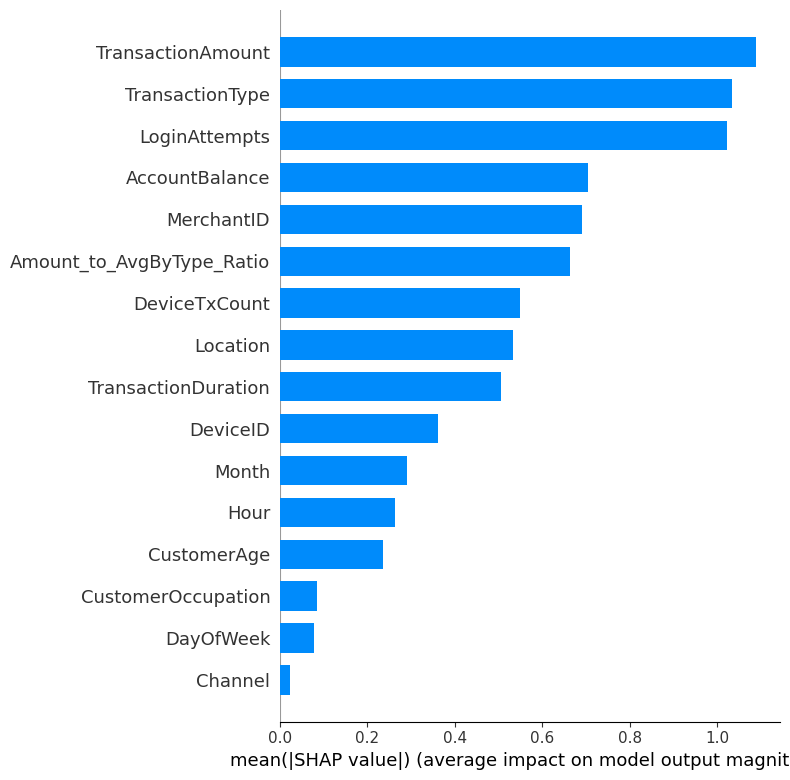

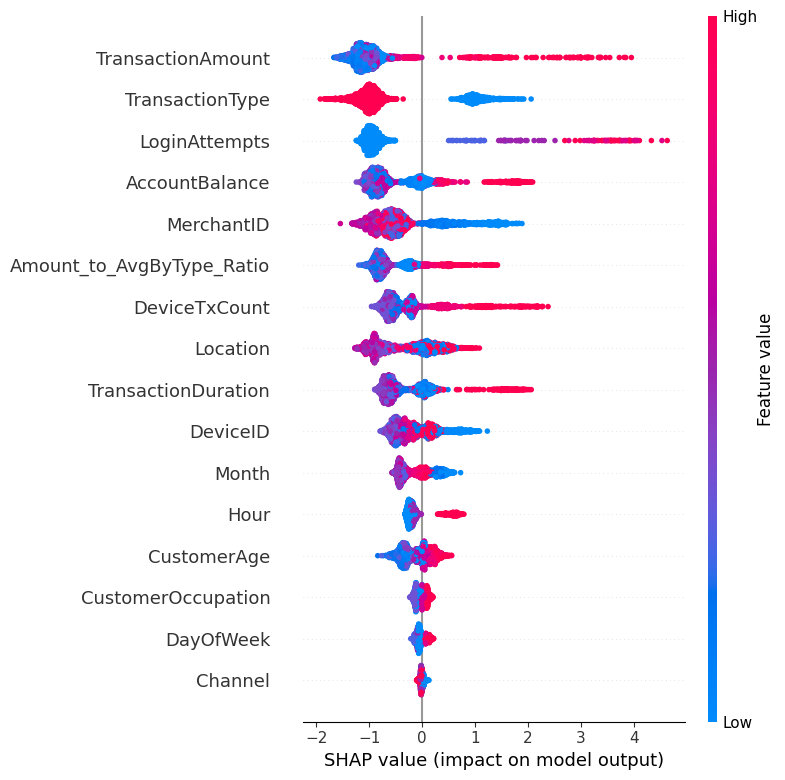

In [134]:
# Define features and labels
X = df_model.drop([
    'MCD_Anomaly', 'MCD_Score', 'IF_Anomaly','IF_Score', 'OCSVM_Anomaly','OCSVM_Score', 'LOF_Anomaly','Ensemble_Anomaly'], axis=1)

y = df_model['Ensemble_Anomaly']

# Train XGBoost model
xgb_model = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(X, y)

# SHAP values
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X)

# Summary plot
shap.summary_plot(shap_values, X, plot_type="bar")

# Detailed beeswarm plot
shap.summary_plot(shap_values, X)

# Decision Tree for Anomaly Detection Rules

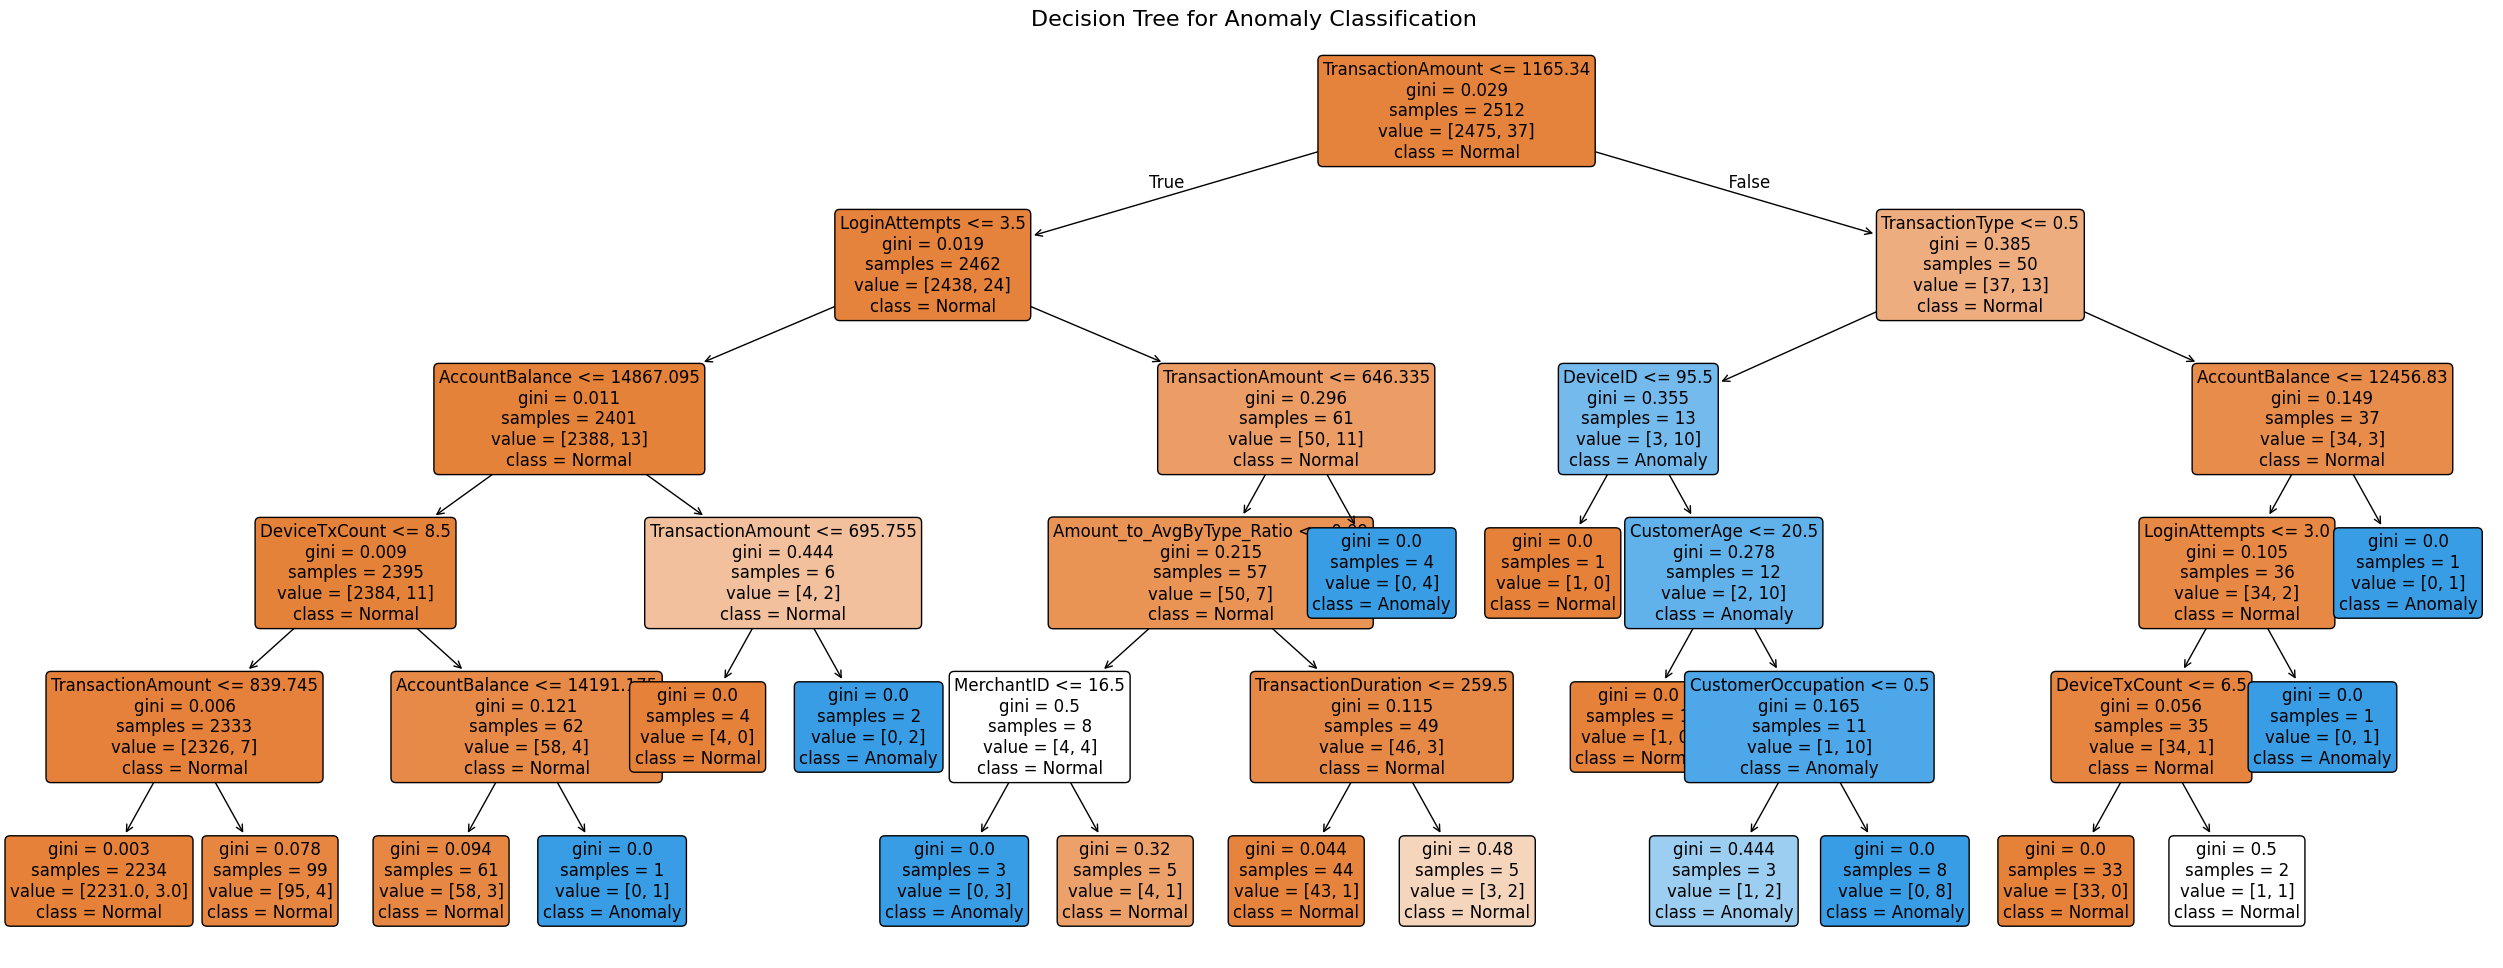


Decision Rules for Identifying Anomalies:

|--- TransactionAmount <= 1165.34
|   |--- LoginAttempts <= 3.50
|   |   |--- AccountBalance <= 14867.09
|   |   |   |--- DeviceTxCount <= 8.50
|   |   |   |   |--- TransactionAmount <= 839.74
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- TransactionAmount >  839.74
|   |   |   |   |   |--- class: 0
|   |   |   |--- DeviceTxCount >  8.50
|   |   |   |   |--- AccountBalance <= 14191.17
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- AccountBalance >  14191.17
|   |   |   |   |   |--- class: 1
|   |   |--- AccountBalance >  14867.09
|   |   |   |--- TransactionAmount <= 695.76
|   |   |   |   |--- class: 0
|   |   |   |--- TransactionAmount >  695.76
|   |   |   |   |--- class: 1
|   |--- LoginAttempts >  3.50
|   |   |--- TransactionAmount <= 646.33
|   |   |   |--- Amount_to_AvgByType_Ratio <= 0.09
|   |   |   |   |--- MerchantID <= 16.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- MerchantID >  16.50
|   |   |   | 

In [135]:
# Train simple decision tree
dt = DecisionTreeClassifier(max_depth=5, random_state=42)
dt.fit(X, y)

# Visualize tree
plt.figure(figsize=(32, 12))
plot_tree(
    dt, 
    filled=True, 
    feature_names=X.columns, 
    class_names=["Normal","Anomaly"], 
    rounded=True,
    fontsize=12
)
plt.title("Decision Tree for Anomaly Classification", fontsize=16)
plt.show()


# Extract decision rules
rules = export_text(dt, feature_names=list(X.columns))
print("\nDecision Rules for Identifying Anomalies:\n")
print(rules)